In [2]:
!bash ex3.sh

/venv/env1/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:32<00:00, 10.81s/it]
Some weights of LlavaForConditionalGenerationScal were not initialized from the model checkpoint at llava-hf/llava-1.5-7b-hf and are newly initialized: ['language_model.model.layers.0.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.1.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.10.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.11.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.12.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.13.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.14.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.15.self

In [3]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

# 1. Load JSON
path = "output/results1.5_VG_QA_two_obj_adapt_vis_research_1.0_0.9_sixoption_True.json"
with open(path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# 2. 정답 여부 판별 함수
def check_is_correct(golden, gen):
    if not isinstance(gen, str):
        return False
    cond1 = (golden in gen) or (golden.lower() in gen.lower())
    cond2 = not (golden.lower() == 'on' and 'front' in gen.strip().lower())
    return cond1 and cond2

# 3. 모든 weight에 대해 is_correct_* 컬럼 생성 (지금은 0.5, 1.0, 1.2만 있다고 가정)
for w in ["0.5", "0.8", "1.0", "1.2", "1.5", "2.0"]:
    col = f"is_correct_{w}"
    if col not in df.columns:
        df[col] = df.apply(
            lambda row: check_is_correct(row["Golden"], row["Generation"].get(w)),
            axis=1
        )

# 4. baseline: 항상 weight = 1.0 사용
acc_10 = df["is_correct_1.0"].mean()
print(f"=== Global Baseline (Always 1.0) ===")
print(f"Baseline Accuracy: {acc_10:.4f}")


=== Global Baseline (Always 1.0) ===
Baseline Accuracy: 0.4077


In [4]:
def analyze_metric_for_pair(
    df,
    metric_col: str,
    low_weight: str,
    high_weight: str,
    valid_choices_col: str,
    strategy_type: str = "high_triggers_high"
):
    """
    metric_col: 'uncertainty_prob', 'uncertainty_entropy', 'uncertainty_jsd'
    low_weight / high_weight: 문자열 ('0.5', '0.8', '1.2', ...)
    valid_choices_col: 각 row마다 [정답이 되는 weight 문자열들] 리스트를 담고 있는 컬럼명
    strategy_type:
        - 'high_triggers_high': metric >= T 이면 high_weight 선택
        - 'low_triggers_high' : metric <= T 이면 high_weight 선택
    """
    values = df[metric_col].values
    thresholds = np.linspace(values.min(), values.max(), 200)
    accuracies = []

    for th in thresholds:
        if strategy_type == "high_triggers_high":
            decisions = df[metric_col].apply(lambda x: high_weight if x >= th else low_weight)
        else:
            decisions = df[metric_col].apply(lambda x: high_weight if x <= th else low_weight)

        correct_count = sum(
            1 for dec, valid in zip(decisions, df[valid_choices_col]) if dec in valid
        )
        accuracies.append(correct_count / len(df))

    best_acc = max(accuracies)
    best_th = thresholds[int(np.argmax(accuracies))]
    return best_acc, best_th, thresholds, accuracies

def build_valid_choices_for_pair(df, low_weight: str, high_weight: str, colname: str):
    """
    low_weight, high_weight에 대해 정답이 되는 weight만 모아 리스트로 저장.
    예: ['0.5', '1.2'], ['0.5'], [], ...
    """
    col_low = f"is_correct_{low_weight}"
    col_high = f"is_correct_{high_weight}"

    def _collect(row):
        choices = []
        if row[col_low]:
            choices.append(low_weight)
        if row[col_high]:
            choices.append(high_weight)
        return choices

    df[colname] = df.apply(_collect, axis=1)

def run_analysis_for_weight_pair(df, low_weight: str, high_weight: str):
    """
    특정 (low_weight, high_weight) 조합에 대해:
    - valid_choices_pair 컬럼 생성
    - Oracle 계산
    - prob / entropy / jsd 각각에 대해 최적 threshold, max acc 계산
    - 그래프 1장으로 기록
    """
    print(f"\n===== Weight Pair: low={low_weight}, high={high_weight} =====")
    valid_col = f"valid_choices_{low_weight}_{high_weight}"

    # 1) valid_choices 구성
    build_valid_choices_for_pair(df, low_weight, high_weight, valid_col)

    # 2) Oracle (둘 중 하나라도 맞으면 맞출 수 있다고 가정)
    acc_oracle = df[valid_col].apply(lambda xs: len(xs) > 0).mean()
    print(f"Oracle Accuracy for this pair: {acc_oracle:.4f}")

    # 3) Metric별 전략 설정
    # - prob: 값이 낮으면 불확실 -> high_weight로 보낼지, 혹은 사용자가 반대 실험도 해보고 싶으면 바꿔도 됨
    #   여기서는 일단 'low_triggers_high' = prob <= T 이면 high_weight 선택
    metric_configs = {
        "uncertainty_prob": "low_triggers_high",   # confidence 낮을 때 high temp
        "uncertainty_entropy": "high_triggers_high",  # entropy 높을 때 high temp
        "uncertainty_jsd": "high_triggers_high",      # jsd 높을 때 high temp (uniform과 멀수록 불확실하다고 가정)
    }

    results = {}

    for metric, strategy in metric_configs.items():
        best_acc, best_th, ths, accs = analyze_metric_for_pair(
            df,
            metric_col=metric,
            low_weight=low_weight,
            high_weight=high_weight,
            valid_choices_col=valid_col,
            strategy_type=strategy,
        )
        results[metric] = {
            "best_acc": best_acc,
            "best_th": best_th,
            "thresholds": ths,
            "accuracies": accs,
        }
        print(
            f"[{metric}] Best Acc: {best_acc:.4f} | "
            f"Best Th: {best_th:.4f} | "
            f"Gain over Baseline(1.0): {(best_acc - acc_10) * 100:.2f}%p"
        )

    # 4) 그래프 기록
    plt.figure(figsize=(10, 7))
    # Baseline / Oracle
    plt.axhline(y=acc_10, color="gray", linestyle="--",
                label=f"Baseline 1.0 ({acc_10:.4f})", alpha=0.7)
    plt.axhline(y=acc_oracle, color="black", linestyle=":",
                label=f"Oracle ({acc_oracle:.4f})", alpha=0.7)

    colors = {
        "uncertainty_prob": "blue",
        "uncertainty_entropy": "red",
        "uncertainty_jsd": "purple",
    }

    for metric, res in results.items():
        plt.plot(
            res["thresholds"],
            res["accuracies"],
            label=f"{metric}",
            color=colors.get(metric, "green"),
        )
        plt.scatter(
            [res["best_th"]],
            [res["best_acc"]],
            color=colors.get(metric, "green"),
            zorder=5,
        )

    plt.title(f"Dynamic Selection (low={low_weight}, high={high_weight})")
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return results



===== Weight Pair: low=0.5, high=1.2 =====
Oracle Accuracy for this pair: 0.4678
[uncertainty_prob] Best Acc: 0.4549 | Best Th: 0.5201 | Gain over Baseline(1.0): 4.72%p
[uncertainty_entropy] Best Acc: 0.4549 | Best Th: 0.6251 | Gain over Baseline(1.0): 4.72%p
[uncertainty_jsd] Best Acc: 0.4506 | Best Th: 0.0080 | Gain over Baseline(1.0): 4.29%p


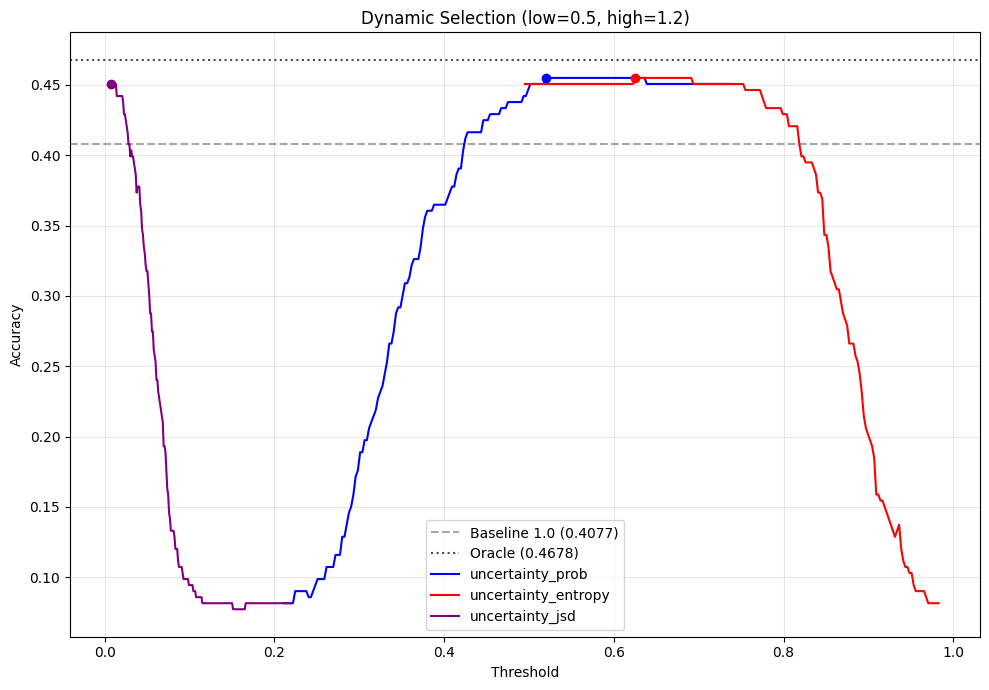

In [5]:
# low temperature candidates (weight1)
low_candidates = ["0.5"]
# high temperature candidates (weight2)
high_candidates = ["1.2"]

all_results = {}

for lw in low_candidates:
    for hw in high_candidates:
        res = run_analysis_for_weight_pair(df, low_weight=lw, high_weight=hw)
        all_results[(lw, hw)] = res
